In [29]:
# Load the relevant packages.
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from scipy import sparse
from intercode import Intercode
import scanorama as scrama

sc.settings.verbosity = 3 # Possible values: (0) errors, (1) warnings, (2) info, (3) hints
sc.settings.set_figure_params(dpi = 100, facecolor='white', fontsize=18, transparent=True)


In [30]:
# Create the custom colourmap
import matplotlib as mpl
from copy import copy
colour_map = copy(mpl.cm.get_cmap('hot_r'))
colour_map.set_under('lightgray')

In [33]:
# Load the processed fibroblast data
results_directory = '../data/' # Initialise the results file
results_directory = '/Users/axelalmet/Documents/CellCellCommunicationModelling/Data/IntegratedData/'

In [34]:
# Load the file
file_name = 'integratedfibroblastsdata.h5ad'
fibroblasts_merged = sc.read_h5ad(results_directory + file_name)

In [35]:
# Load the different functional gene sets
ecm_synthesis_genes = pd.read_csv(results_directory + 'fibroblast_ecm_structural_genes.csv')['0'].tolist()
ecm_modifying_genes = pd.read_csv(results_directory + 'fibroblast_ecm_modifying_genes.csv')['0'].tolist()
signal_ligands = pd.read_csv(results_directory + 'fibroblast_signal_ligands.csv')['0'].tolist()
signal_receptors = pd.read_csv(results_directory + 'fibroblast_signal_receptors.csv')['0'].tolist()

functional_genes = list(set(ecm_synthesis_genes + ecm_modifying_genes + signal_ligands + signal_receptors))
other_genes = [gene for gene in fibroblasts_merged.var_names if gene not in functional_genes]

In [6]:
# Subset the fibroblast data on the different gene sets 
fibroblasts_functional = fibroblasts_merged[:, functional_genes]
fibroblasts_other_functional = fibroblasts_merged[:, other_genes]
fibroblasts_ecm_syn = fibroblasts_merged[:, ecm_synthesis_genes]
fibroblasts_ecm_mod = fibroblasts_merged[:, ecm_modifying_genes]
fibroblasts_sig_lig = fibroblasts_merged[:, signal_ligands]
fibroblasts_sig_rec = fibroblasts_merged[:, signal_receptors]

# Subcluster for each of the functional gene sets

Note that due to the lower variable sizes (no. genes), we don't really have to calculate HVGs for any of the datasets, bar the 'other functional' dataset. 

## Fibroblast functionality genes

In [7]:
# Split the data into batches (marked by 'sample')
fibroblast_functional_split = []

for sample in fibroblasts_functional.obs['sample'].unique():
    fibroblast_functional_split.append(fibroblasts_functional[fibroblasts_functional.obs['sample']==sample].copy())

In [8]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_functional_split, ds_names = list(fibroblasts_functional.obs['sample'].unique()))

After UW P49: 1269 genes
After SW PWD4: 1269 genes
After LW PWD12: 1269 genes
After LW PWD14: 1269 genes
After LW FIB PWD18: 1269 genes
After LW REG PWD18: 1269 genes
After UW P21: 1269 genes
After SW PWD7: 1269 genes
Found 1269 genes among all datasets
[[0.00000000e+00 7.91291291e-01 1.50150150e-03 1.42642643e-02
  4.33369447e-03 7.50750751e-04 2.13447653e-01 3.47771103e-03]
 [0.00000000e+00 0.00000000e+00 6.72374519e-02 2.75059508e-01
  7.04225352e-02 4.75038867e-02 4.29602888e-01 9.45305090e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.26395134e-01
  1.63596966e-01 1.02662792e-01 9.47653430e-03 8.53619981e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.81798483e-01 3.43295424e-01 1.77797834e-01 1.22352197e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.53412784e-01 2.60021668e-02 5.52546046e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.23465704e-02 2.38868664e-

In [9]:
embeddings_functional = [adata.obsm['X_scanorama'] for adata in fibroblast_functional_split]
embeddings_functional_joined = np.concatenate(embeddings_functional, axis=0)
fibroblasts_functional.obsm['X_SC_FUN'] = embeddings_functional_joined

In [10]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_functional, use_rep = 'X_SC_FUN', n_neighbors=30)
sc.tl.umap(fibroblasts_functional)

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)


In [11]:
# Cluster the data now
sc.tl.leiden(fibroblasts_functional, resolution = 0.75, key_added = 'leiden_fun')

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_fun', the cluster labels (adata.obs, categorical) (0:00:20)


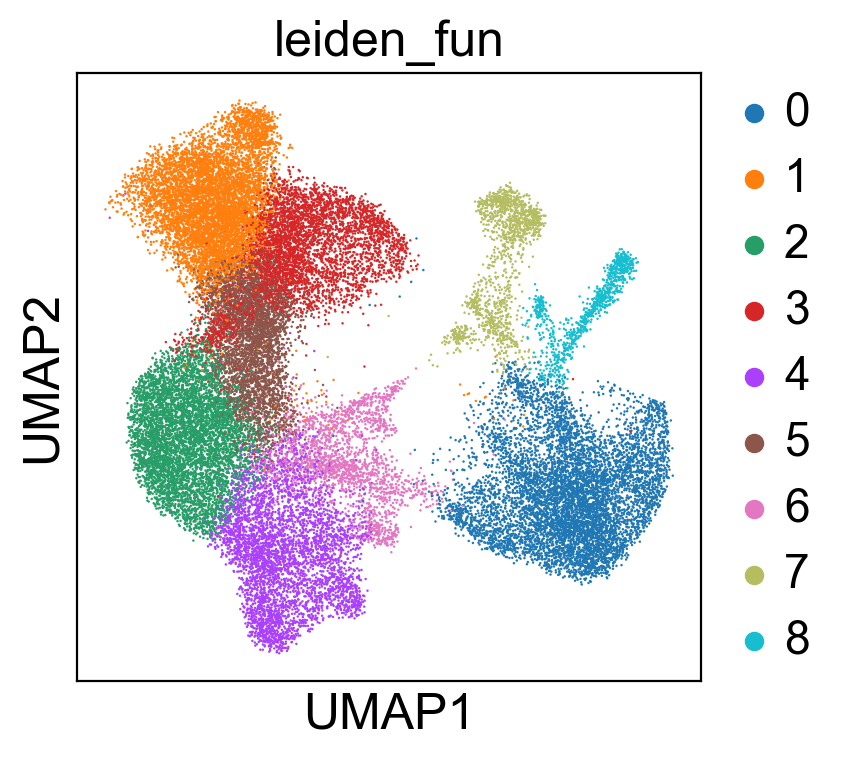

In [12]:
sc.pl.umap(fibroblasts_functional, color='leiden_fun')

In [13]:
# Rename the clusters
functional_cluster_names = ['FUN-1', 'FUN-2', 'FUN-3', 'FUN-4',\
                            'FUN-5', 'FUN-6', 'FUN-7', 'FUN-8',\
                            'FUN-9']
fibroblasts_functional.rename_categories('leiden_fun', functional_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


## ECM synthesis genes

In [21]:
# Split the data into batches (marked by 'sample')
fibroblast_ecm_syn_split = []

for sample in fibroblasts_ecm_syn.obs['sample'].unique():
    fibroblast_ecm_syn_split.append(fibroblasts_ecm_syn[fibroblasts_ecm_syn.obs['sample']==sample].copy())

In [22]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_ecm_syn_split, ds_names = list(fibroblasts_ecm_syn.obs['sample'].unique()))

After UW P49: 416 genes
After SW PWD4: 416 genes
After LW PWD12: 416 genes
After LW PWD14: 416 genes
After LW FIB PWD18: 416 genes
After LW REG PWD18: 416 genes
After UW P21: 416 genes
After SW PWD7: 416 genes
Found 416 genes among all datasets
[[0.00000000e+00 8.64489489e-01 2.25225225e-03 2.02702703e-02
  0.00000000e+00 3.75375375e-04 2.24277978e-01 4.42617768e-03]
 [0.00000000e+00 0.00000000e+00 6.38598696e-02 2.96746892e-01
  9.10075840e-02 6.14959406e-02 5.13989170e-01 5.56433765e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72705633e-01
  2.79523294e-01 1.84274605e-01 1.53429603e-02 4.04679102e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.02383532e-01 3.54932558e-01 1.74187726e-01 1.16345242e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.14409534e-01 2.38353196e-02 8.34236186e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.28700361e-02 3.07756931e-01]
 [0.0

In [23]:
embeddings_ecm_syn = [adata.obsm['X_scanorama'] for adata in fibroblast_ecm_syn_split]
embeddings_ecm_syn_joined = np.concatenate(embeddings_ecm_syn, axis=0)
fibroblasts_ecm_syn.obsm['X_SC_ECM_SYN'] = embeddings_ecm_syn_joined

In [24]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_ecm_syn, use_rep = 'X_SC_ECM_SYN', n_neighbors=30)
sc.tl.umap(fibroblasts_ecm_syn)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


In [25]:
# Cluster the data now
sc.tl.leiden(fibroblasts_ecm_syn, resolution = 0.9, key_added = 'leiden_ecm_syn')

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_ecm_syn', the cluster labels (adata.obs, categorical) (0:00:15)


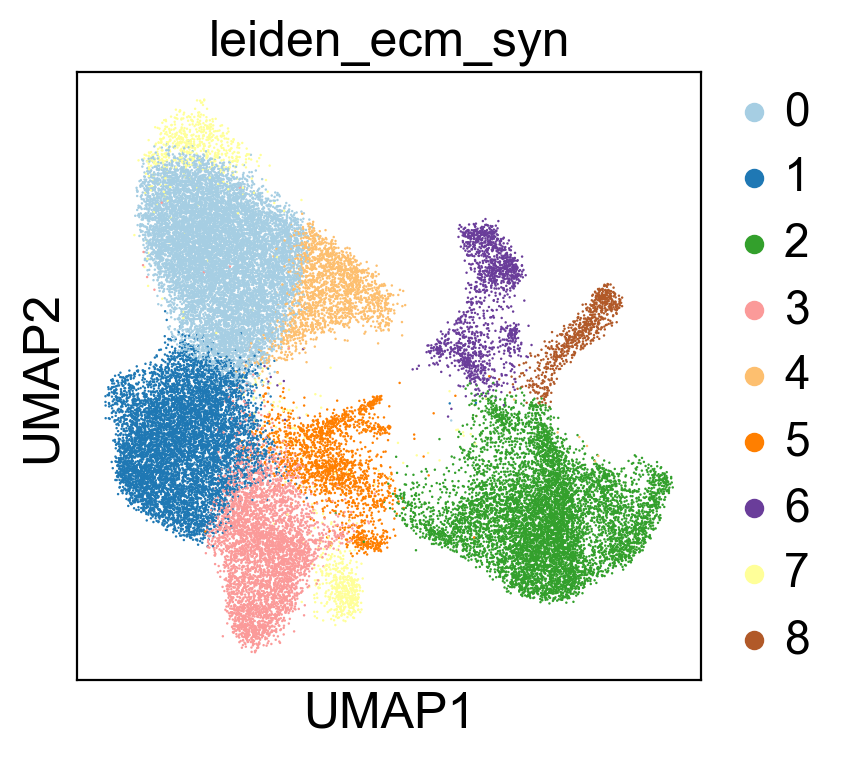

In [26]:
sc.pl.umap(fibroblasts_ecm_syn, color='leiden_ecm_syn', palette='Paired')

In [27]:
# Rename the clusters
ecm_syn_cluster_names = ['SYN-1', 'SYN-2', 'SYN-3', 'SYN-4',\
                        'SYN-5', 'SYN-6', 'SYN-7', 'SYN-8',\
                        'SYN-9']
fibroblasts_ecm_syn.rename_categories('leiden_ecm_syn', ecm_syn_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


## ECM modifying genes

In [90]:
# Split the data into batches (marked by 'sample')
fibroblast_ecm_mod_split = []

for sample in fibroblasts_ecm_mod.obs['sample'].unique():
    fibroblast_ecm_mod_split.append(fibroblasts_ecm_mod[fibroblasts_ecm_mod.obs['sample']==sample].copy())

In [91]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_ecm_mod_split, ds_names = list(fibroblasts_ecm_mod.obs['sample'].unique()))

After UW P49: 228 genes
After SW PWD4: 228 genes
After LW PWD12: 228 genes
After LW PWD14: 228 genes
After LW FIB PWD18: 228 genes
After LW REG PWD18: 228 genes
After UW P21: 228 genes
After SW PWD7: 228 genes
Found 228 genes among all datasets
[[0.         0.83896396 0.06981982 0.04016517 0.01950163 0.05780781
  0.27978339 0.10472973]
 [0.         0.         0.14493004 0.33060037 0.13976165 0.17550527
  0.28700361 0.19222257]
 [0.         0.         0.         0.18090452 0.22210184 0.3316998
  0.32987365 0.31836864]
 [0.         0.         0.         0.         0.50704225 0.55117694
  0.05685921 0.05627569]
 [0.         0.         0.         0.         0.         0.843987
  0.07150596 0.08884074]
 [0.         0.         0.         0.         0.         0.
  0.2734657  0.42428075]
 [0.         0.         0.         0.         0.         0.
  0.         0.76624549]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets LW FIB PWD18 <=> 

In [92]:
embeddings_ecm_mod = [adata.obsm['X_scanorama'] for adata in fibroblast_ecm_mod_split]
embeddings_ecm_mod_joined = np.concatenate(embeddings_ecm_mod, axis=0)
fibroblasts_ecm_mod.obsm['X_SC_ECM_MOD'] = embeddings_ecm_mod_joined

In [93]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_ecm_mod, use_rep = 'X_SC_ECM_MOD', n_neighbors=30)
sc.tl.umap(fibroblasts_ecm_mod)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


In [94]:
# Cluster the data now
sc.tl.leiden(fibroblasts_ecm_mod, resolution = 0.4, key_added = 'leiden_ecm_mod')

running Leiden clustering
    finished: found 4 clusters and added
    'leiden_ecm_mod', the cluster labels (adata.obs, categorical) (0:00:16)


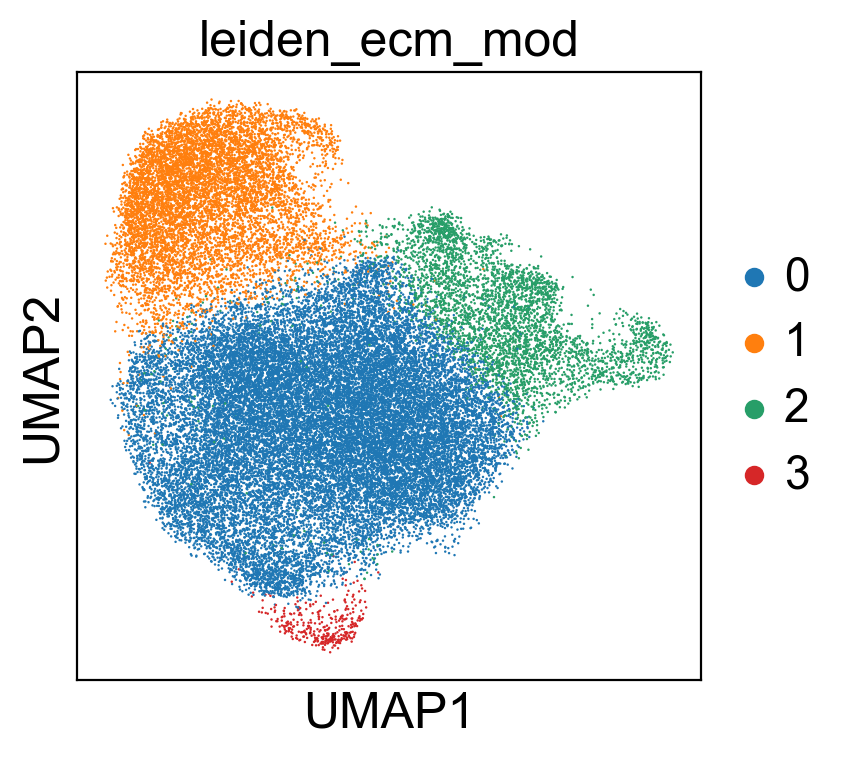

In [95]:
sc.pl.umap(fibroblasts_ecm_mod, color='leiden_ecm_mod', palette='Paired')

In [105]:
# Rename the clusters
ecm_mod_cluster_names = ['MOD-1', 'MOD-2', 'MOD-3', 'MOD-4']
fibroblasts_ecm_mod.rename_categories('leiden_ecm_mod', ecm_mod_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


## Signal ligands

In [107]:
# Split the data into batches (marked by 'sample')
fibroblast_sig_lig_split = []

for sample in fibroblasts_sig_lig.obs['sample'].unique():
    fibroblast_sig_lig_split.append(fibroblasts_sig_lig[fibroblasts_sig_lig.obs['sample']==sample].copy())

In [108]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_sig_lig_split, ds_names = list(fibroblasts_sig_lig.obs['sample'].unique()))

After UW P49: 435 genes
After SW PWD4: 435 genes
After LW PWD12: 435 genes
After LW PWD14: 435 genes
After LW FIB PWD18: 435 genes
After LW REG PWD18: 435 genes
After UW P21: 435 genes
After SW PWD7: 435 genes
Found 435 genes among all datasets
[[0.         0.85885886 0.01313814 0.03791291 0.02383532 0.02665165
  0.32626354 0.11261261]
 [0.         0.         0.14107297 0.1618587  0.1148429  0.0963897
  0.33619134 0.3363895 ]
 [0.         0.         0.         0.44221106 0.17009751 0.23900868
  0.13898917 0.3335441 ]
 [0.         0.         0.         0.         0.40736728 0.55911135
  0.11281588 0.1735694 ]
 [0.         0.         0.         0.         0.         0.90899242
  0.07150596 0.1007584 ]
 [0.         0.         0.         0.         0.         0.
  0.31498195 0.28643693]
 [0.         0.         0.         0.         0.         0.
  0.         0.74774368]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets LW FIB PWD18 <=

In [109]:
embeddings_sig_lig = [adata.obsm['X_scanorama'] for adata in fibroblast_sig_lig_split]
embeddings_sig_lig_joined = np.concatenate(embeddings_sig_lig, axis=0)
fibroblasts_sig_lig.obsm['X_SC_SIG_LIG'] = embeddings_sig_lig_joined

In [111]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_sig_lig, use_rep = 'X_SC_SIG_LIG', n_neighbors=30)
sc.tl.umap(fibroblasts_sig_lig)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


In [115]:
# Cluster the data now
sc.tl.leiden(fibroblasts_sig_lig, resolution = 0.7, key_added = 'leiden_sig_lig')

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_sig_lig', the cluster labels (adata.obs, categorical) (0:00:25)


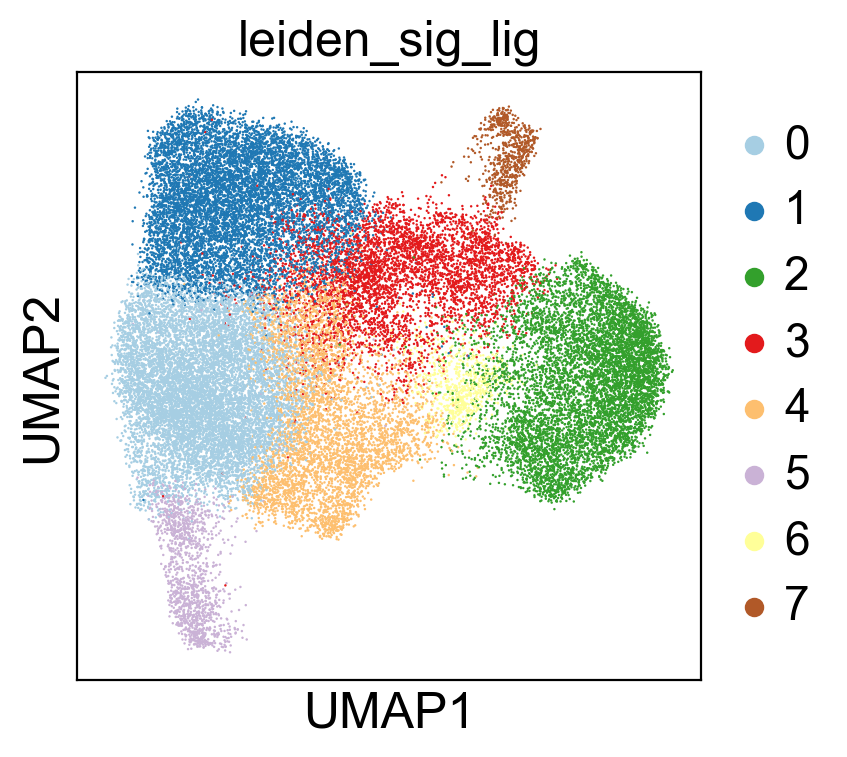

In [116]:
sc.pl.umap(fibroblasts_sig_lig, color='leiden_sig_lig', palette='Paired')

In [85]:
# Rename the clusters
sig_lig_cluster_names = ['SIG-1', 'SIG-2', 'SIG-3', 'SIG-4',\
                            'SIG-5', 'SIG-6', 'SIG-7', 'SIG-8']
fibroblasts_sig_lig.rename_categories('leiden_sig_lig', sig_lig_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


## Signal receptors

In [117]:
# Split the data into batches (marked by 'sample')
fibroblast_sig_rec_split = []

for sample in fibroblasts_sig_rec.obs['sample'].unique():
    fibroblast_sig_rec_split.append(fibroblasts_sig_rec[fibroblasts_sig_rec.obs['sample']==sample].copy())

In [118]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_sig_rec_split, ds_names = list(fibroblasts_sig_rec.obs['sample'].unique()))

After UW P49: 351 genes
After SW PWD4: 351 genes
After LW PWD12: 351 genes
After LW PWD14: 351 genes
After LW FIB PWD18: 351 genes
After LW REG PWD18: 351 genes
After UW P21: 351 genes
After SW PWD7: 351 genes
Found 351 genes among all datasets
[[0.         0.871997   0.07995495 0.02627628 0.00866739 0.04429429
  0.15974729 0.09459459]
 [0.         0.         0.18780928 0.19915366 0.156013   0.15736742
  0.16696751 0.14701233]
 [0.         0.         0.         0.2335361  0.30335861 0.47367684
  0.39034296 0.47202023]
 [0.         0.         0.         0.         0.3716143  0.50727321
  0.05505415 0.06449573]
 [0.         0.         0.         0.         0.         0.62621885
  0.05308776 0.10184182]
 [0.         0.         0.         0.         0.         0.
  0.34702166 0.47138792]
 [0.         0.         0.         0.         0.         0.
  0.         0.58799639]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets UW P49 <=> SW 

In [119]:
embeddings_sig_rec = [adata.obsm['X_scanorama'] for adata in fibroblast_sig_rec_split]
embeddings_sig_rec_joined = np.concatenate(embeddings_sig_rec, axis=0)
fibroblasts_sig_rec.obsm['X_SC_SIG_REC'] = embeddings_sig_rec_joined

In [120]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_sig_rec, use_rep = 'X_SC_SIG_REC', n_neighbors=30)
sc.tl.umap(fibroblasts_sig_rec)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


In [150]:
# Cluster the data now
sc.tl.leiden(fibroblasts_sig_rec, resolution = 0.4, key_added = 'leiden_sig_rec')

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_sig_rec', the cluster labels (adata.obs, categorical) (0:00:24)


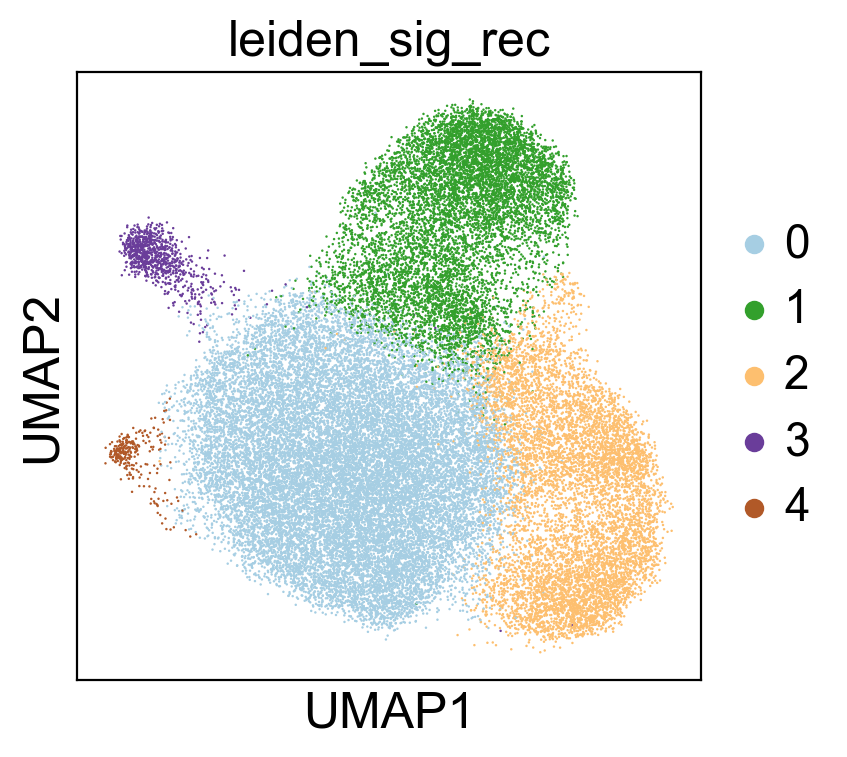

In [152]:
sc.pl.umap(fibroblasts_sig_rec, color='leiden_sig_rec', palette='Paired')

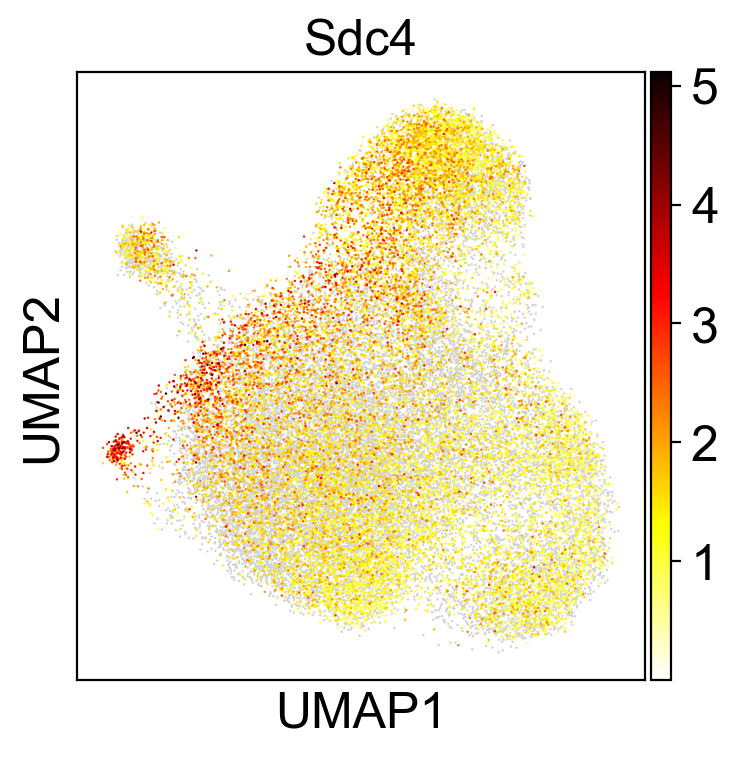

In [141]:
sc.pl.umap(fibroblasts_sig_rec, color='Sdc4', cmap=colour_map, vmin=0.0001)

In [85]:
# Rename the clusters
sig_rec_cluster_names = ['REC-1', 'REC-2', 'REC-3', 'REC-4', 'REG-5']
fibroblasts_sig_rec.rename_categories('leiden_sig_rec', sig_rec_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


# The remaining genes (many of which are functional but not necessarily specific to fibroblasts)

In [157]:
# Identify the highly-variable genes. We use the CellRanger routine provided in Scanpy.
target_genes = 2000
sc.pp.highly_variable_genes(fibroblasts_other_functional, flavor='cell_ranger', n_top_genes=target_genes, batch_key='sample')

# As we don't have enough target genes, we need to consider HVGs in all but one batches.
n_batches = len(fibroblasts_other_functional.obs['sample'].cat.categories)
# These are the genes that are variable across all batches
nbatch1_dispersions = fibroblasts_other_functional.var['dispersions_norm'][fibroblasts_other_functional.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

# Fill up the genes now, using this method from the Theis lab
enough = False
hvg_fibroblast = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single gbatch
while not enough:
    
    target_genes_diff = target_genes - len(hvg_fibroblast) # Get the number of genes we still need to fill up
    
    tmp_dispersions = fibroblasts_other_functional.var['dispersions_norm'][fibroblasts_other_functional.var.highly_variable_nbatches == (n_batches - not_n_batches)]
    
    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:
        
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index)
        not_n_batches += 1
        
    else:
        
        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg_fibroblast = hvg_fibroblast.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas

    finished (0:00:12)


/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/usr/local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
89


In [159]:
fibroblast_other_functional_hvg = fibroblasts_other_functional.copy()
fibroblast_other_functional_hvg = fibroblast_other_functional_hvg[:, hvg_fibroblast]

In [161]:
# Split the data into batches (marked by 'sample')
fibroblast_other_functional_split = []

for sample in fibroblast_other_functional_hvg.obs['sample'].unique():
    fibroblast_other_functional_split.append(fibroblast_other_functional_hvg[fibroblast_other_functional_hvg.obs['sample']==sample].copy())

In [162]:
%%time
# Now we run Scanorama on the split data.
scrama.integrate_scanpy(fibroblast_other_functional_split, ds_names = list(fibroblast_other_functional_hvg.obs['sample'].unique()))

After UW P49: 2000 genes
After SW PWD4: 2000 genes
After LW PWD12: 2000 genes
After LW PWD14: 2000 genes
After LW FIB PWD18: 2000 genes
After LW REG PWD18: 2000 genes
After UW P21: 2000 genes
After SW PWD7: 2000 genes
Found 2000 genes among all datasets
[[0.00000000e+00 8.42717718e-01 3.75375375e-04 9.38438438e-03
  4.33369447e-03 3.75375375e-03 1.92689531e-01 8.85235536e-03]
 [0.00000000e+00 0.00000000e+00 1.27562642e-01 2.88019043e-01
  7.36728061e-02 4.52582484e-02 4.76985560e-01 1.93487196e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.32451732e-01
  9.85915493e-02 6.83281994e-02 2.84296029e-02 2.02971862e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.76381365e-01 4.36656969e-01 1.53429603e-01 7.68257983e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.57746479e-01 4.22535211e-02 5.30877573e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.02527076e-02 2.46149538e-

In [165]:
embeddings_other_functional = [adata.obsm['X_scanorama'] for adata in fibroblast_other_functional_split]
embeddings_other_functional_joined = np.concatenate(embeddings_other_functional, axis=0)
fibroblasts_other_functional.obsm['X_SC_OTH'] = embeddings_other_functional_joined

In [178]:
# Run PCA just to see the variation across samples
sc.pp.neighbors(fibroblasts_other_functional, use_rep = 'X_SC_OTH', n_neighbors=30)
sc.tl.umap(fibroblasts_other_functional)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


In [184]:
# Cluster the data now
sc.tl.leiden(fibroblasts_other_functional, resolution = 0.7, key_added = 'leiden_other')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_other', the cluster labels (adata.obs, categorical) (0:00:19)


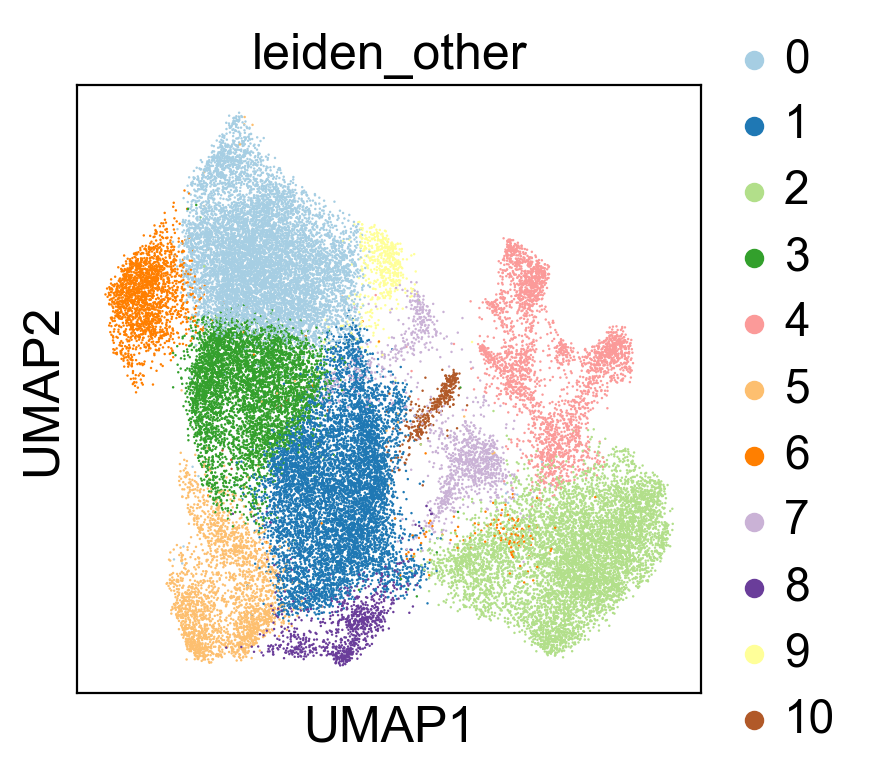

In [185]:
sc.pl.umap(fibroblasts_other_functional, color='leiden_other', palette='Paired')

In [186]:
# Rename the clusters
other_functional_cluster_names = ['OTH-1', 'OTH-2', 'OTH-3', 'OTH-4', 'OTH-5',\
                                  'OTH-6', 'OTH-7', 'OTH-8', 'OTH-9', 'OTH-10',\
                                  'OTH-11']
fibroblasts_other_functional.rename_categories('leiden_other', other_functional_cluster_names)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


# Compare functional cluster annotations with original subcluster labels

In [17]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [30]:
original_subcluster_labels = fibroblasts_merged.obs['leiden_sub'].values
functional_subcluster_labels = fibroblasts_functional.obs['leiden_fun'].values
ecm_synthesis_subcluster_labels = fibroblasts_ecm_syn.obs['leiden_ecm_syn'].values
ecm_modifying_subcluster_labels = fibroblasts_ecm_mod['leiden_ecm_mod'].values
signal_ligand_subcluster_labels = fibroblasts_sig_lig.obs['leiden_sig_lig'].values
signal_receptor_subcluster_labels = fibroblasts_sig_rec.obs['leiden_sig_rec'].values
other_functional_subcluster_labels = fibroblasts_other_functional.obs['leiden_other'].values

In [34]:
# Calculate the adjusted rand indices
ari_other_fun = adjusted_rand_score(original_subcluster_labels, other_functional_subcluster_labels)
ari_fun = adjusted_rand_score(original_subcluster_labels, functional_subcluster_labels)
ari_ecm_syn = adjusted_rand_score(original_subcluster_labels, ecm_synthesis_subcluster_labels)
ari_sig_lig = adjusted_rand_score(original_subcluster_labels, signal_ligand_subcluster_labels)
ari_ecm_mod = adjusted_rand_score(original_subcluster_labels, ecm_modifying_subcluster_labels)
ari_sig_rec = adjusted_rand_score(original_subcluster_labels, signal_receptor_subcluster_labels)

# Calculate the normalized mutual information
nmi_other_fun = normalized_mutual_info_score(original_subcluster_labels, other_functional_subcluster_labels)
nmi_fun = normalized_mutual_info_score(original_subcluster_labels, functional_subcluster_labels)
nmi_ecm_syn = normalized_mutual_info_score(original_subcluster_labels, ecm_synthesis_subcluster_labels)
nmi_sig_lig = normalized_mutual_info_score(original_subcluster_labels, signal_ligand_subcluster_labels)
nmi_ecm_mod = normalized_mutual_info_score(original_subcluster_labels, ecm_modifying_subcluster_labels)
nmi_sig_rec = normalized_mutual_info_score(original_subcluster_labels, signal_receptor_subcluster_labels)

In [3]:
cluster_similarities = pd.DataFrame({'Clustering similarity':[ari_other_fun,\
                                                             ari_fun,\
                                                             ari_ecm_syn,\
                                                             ari_sig_lig,\
                                                             ari_ecm_mod,\
                                                             ari_sig_rec,\
                                                             nmi_other_fun,\
                                                             nmi_fun,\
                                                             nmi_ecm_syn,\
                                                             nmi_sig_lig,\
                                                             nmi_ecm_mod,\
                                                             nmi_sig_rec]})
                                                              
cluster_similarities['Score'] = ['ARI', 'ARI', 'ARI', 'ARI', 'ARI', 'ARI',\
                                 'NMI', 'NMI', 'NMI', 'NMI', 'NMI', 'NMI']
cluster_similarities['Comparison'] = ['Other functionality', 'All functionality', 'ECM synthesis',\
                                      'Signal ligand', 'ECM modifying', 'Signal receptor',\
                                     'Other functionality', 'All functionality', 'ECM synthesis',\
                                      'Signal ligand', 'ECM modifying', 'Signal receptor']


In [24]:
cluster_similarities_dfp = cluster_similarities.pivot(index='Score', columns='Comparison', values='Clustering similarity')
cluster_similarities_dfp = cluster_similarities_dfp[['Other functionality', 'All functionality', 'ECM synthesis',\
                          'Signal ligand', 'ECM modifying', 'Signal receptor']]

In [ ]:
ax = cluster_similarities_dfp.plot(kind='bar', figsize=(6, 4))
ax.set(ylabel='Clustering similarity')
ax.legend(title='Attribute', bbox_to_anchor=(1, 1), loc='upper left')

# Train data using autoencoder to see where significant axes of variation are

Since signal receptors are so non-informative, we will not include them when training the autoencoder.

In [36]:
fibroblasts_intercode = fibroblasts_merged.copy()

# [:, ecm_synthesis_genes + ecm_modifying_genes + signal_ligands]

In [50]:
# Define the annotation matrix
I = np.zeros((fibroblasts_intercode.n_vars, 3))

# Add the annotations

I[fibroblasts_intercode.var.index.get_indexer(ecm_synthesis_genes), 0] = 1 # ECM synthesis
I[fibroblasts_intercode.var.index.get_indexer(ecm_modifying_genes), 1] = 1 # ECM modifying
I[fibroblasts_intercode.var.index.get_indexer(signal_ligands), 2] = 1 # Signal ligand

In [52]:
fibroblasts_intercode.varm['I'] = I
fibroblasts_intercode.uns['terms'] = ['ECM synthesis', 'ECM modifying', 'Signal ligand']

In [53]:
# Subset on the annotation matrix
select_genes = fibroblasts_intercode.varm['I'].sum(1)>0
fibroblasts_intercode._inplace_subset_var(select_genes)
fibroblasts_intercode.X -= fibroblasts_intercode.X.mean(0)

In [ ]:
LR = 0.001
BATCH_SIZE = 64
N_EPOCHS = 50

# regularization hyperparameters
# lambda0 - page 19 of presentation
# lambdas 1-3 - last term on page 20

LAMBDA0 = 0.1

LAMBDA1 = 0.93
LAMBDA3 = 0.57

In [ ]:
intercode = Intercode(adata)

In [ ]:
intercode.train(LR, BATCH_SIZE, N_EPOCHS, l2_reg_lambda0=LAMBDA0, lambda1=LAMBDA1, lambda3=LAMBDA3)

In [28]:
# Define this helper function to plot confidence ellipses
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
# Get the latent encodings
terms = ('ECM synthesis', 'ECM modifying', 'Signal ligand')
encoded = intercode.encode(fibroblasts_intercode.X, term_names=terms)

# Add them as observations
fibroblasts_intercode.obs['ECM synthesis'] = encoded[:, 0]
fibroblasts_intercode.obs['ECM modifying'] = encoded[:, 1]
fibroblasts_intercode.obs['Signal ligand'] = encoded[:, 2]

In [ ]:
# Plot the scatterplots with the subclusters coloured
ax_subclusters_syn_lig = sc.pl.scatter(fibroblasts_intercode,
                               y='ECM synthesis', x='Signal ligand', color='leiden_sub', show=False)
ax_subclusters_mod_lig = sc.pl.scatter(fibroblasts_intercode,
                               y='ECM modifying', x='Signal ligand', color='leiden_sub', show=False)
ax_subclusters_syn_mod = sc.pl.scatter(fibroblasts_intercode,
                               y='ECM modifying', x='ECM synthesis', color='leiden_sub', show=False)


In [57]:
terms = ('ECM synthesis', 'ECM modifying', 'Signal ligand')

In [64]:
# Plot the pairwise scatterplots per term
terms_list = list(terms)
subcluster_labels = fibroblasts_intercode.obs['leiden_sub'].value_counts().index.tolist()
subcluster_colours = fibroblasts_intercode.uns['leiden_sub_colors']

In [ ]:
# Add the confidence ellipse per cluster

for i, cluster in enumerate(subcluster_labels):
    
    cluster_indices = np.where(fibroblasts_intercode.obs['leiden_sub'] == cluster)[0]
    
    # For ECM synthesis and signal ligand
    x_subset = encoded[cluster_indices, 2]
    y_subset = encoded[cluster_indices, 0]
    confidence_ellipse(x_subset, y_subset, ax=ax_subclusters_syn_lig,
                    n_std=2.0, facecolor='none', edgecolor=subcluster_colours[i])

    # For ECM synthesis and signal ligand
    x_subset = encoded[cluster_indices, 2]
    y_subset = encoded[cluster_indices, 1]
    confidence_ellipse(x_subset, y_subset, ax=ax_subclusters_mod_lig,
                    n_std=2.0, facecolor='none', edgecolor=subcluster_colours[i])

    # For ECM modifying and ECM synthesis
    x_subset = encoded[cluster_indices, 0]
    y_subset = encoded[cluster_indices, 1]
    confidence_ellipse(x_subset, y_subset, ax=ax_subclusters_syn_mod,
                    n_std=2.0, facecolor='none', edgecolor=subcluster_colours[i])

# Differential expression of two main functional gene sets, ECM synthesis and signal ligands

Plot the differentially expressed ECM synthesis genes.

In [ ]:
sc.tl.rank_genes_groups(fibroblasts_ecm_syn, groupby='leiden_sub', key_added='leiden_sub', method='wilcoxon', use_raw=False)
sc.tl.rank_genes_groups(fibroblasts_ecm_syn, groupby='sample', key_added='sample', method='wilcoxon', use_raw=False)

In [ ]:
heatmap_genes_ecm_syn = ['Dcn', 'Lum', 'Col1a1', 'Col1a2', 'Col3a1',\
                        'Col4a1', 'Caol4a2', 'Col5a1', 'Col5a2', 'Col6a1', 'Col6a2',\
                         'Col23a1', 'Lamc3',
                         'Coch',\
                        'Pcolce2', 'Rspo1', \
                         'Sod3', 'Has1', 'Anxa3', 'Ptx3', 'Prg4',\
                        'Dsp', \
                        'Srgn', 'Tnc', 'Tnn', 'Spon1',\
                         'Col7a1', 'Col12a1', 'Col25a1', \
                        'Col14a1', 'Col8a1', 'Mgp','Matn4']

plt.rcParams['figure.figsize'] = (8, 8)
sc.pl.heatmap(fibroblasts_ecm_syn,
              var_names=heatmap_genes_ecm_syn,
              use_raw=True,
              groupby='sample',
              cmap='Spectral_r',
              swap_axes=True,
             vmax=3.5,
             vmin=0.0)

Plot the differentially expressed signal ligands.

In [ ]:
sc.tl.rank_genes_groups(fibroblasts_sig_lig, groupby='leiden_sub', key_added='leiden_sub', method='wilcoxon', use_raw=False)
sc.tl.rank_genes_groups(fibroblasts_sig_lig, groupby='sample', key_added='sample', method='wilcoxon', use_raw=False)

In [ ]:
heatmap_genes_sig_lig = ['Rarres2', 'Postn', 'Mif', 'Thy1', 'Cd34', 'Anxa1', 'Tgfb1', 'Tgfb2', \
                         'Wnt6', 'Dll1',  'Bmp7', 'Bmp4',\
                        'Cadm3', 'Ccl11', 'Ccl19', 'Cdh4', 'Flt3l',\
                          'Cxcl12', 'Il6', 'C4b', 'Il33', 'Cxcl1', 'Ccl2', 'Ccl7',\
                         'Ccl27a', 'Wnt4', 'Cdh1',\
                         'Spp1', 'Il1b', 'Cxcl5', \
                         'Pdgfd', 'Igf2',
                         'Cxcl10', \
                         'Dlk1', 'Tgfb3', 'Il33', 'Sema3d',\
                          'Vegfd']

plt.rcParams['figure.figsize'] = (12, 12)
sc.pl.heatmap(fibroblasts_sig_lig,
              var_names=heatmap_genes_sig_lig,
              use_raw=True,
              groupby='sample',
              cmap='Spectral_r',
              swap_axes=True,
              show_gene_labels=True,
             vmax=3.5,
             vmin=0)